#### **Packages**

In [33]:
# Importing the required libraries
from datetime import datetime

import pandas as pd
import numpy as np

#Numba is used within Python scripts to accelerate specific functions. 
#You annotate functions with decorators to compile them to machine code. 

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
#OneHotEncoder is used when you have more than 2 categories (like places)
#LabelEncoder is used when you have only 2 categories (like gender)
#StandardScaler is to transform the data. This helps us to find optimize (find global minimum) faster.
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
#RandomForests work by training individuals decisions tree with randomized parameters and then averaging these results.
#Thanks to that, RandomForest are more resistant to overfitting. However, decision trees have a tendency to overfitting.
#They can pick up non-linear tendencies in the data
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import  mean_absolute_error, mean_squared_error, accuracy_score, precision_score
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, cross_val_score, TimeSeriesSplit, KFold
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import statsmodels.api as sm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense, Activation, Embedding, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.activations import relu, sigmoid
import xgboost
from xgboost import cv, DMatrix

from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import pandas_ta as ta

import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.offline as py
import plotly.express as px
import statsmodels.api as sm

py.init_notebook_mode() #It initializes Plotly's offline mode in a Jupyter Notebook, allowing Plotly graphs to be displayed within the notebook. This is useful when you're working offline or don't want to use Plotly's cloud services for rendering your charts. 
%matplotlib inline 
#command that makes matplotlib plots appear inline within the notebook, directly below the code cells that produce them.

import warnings
warnings.filterwarnings('ignore')

In [34]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

#### Read file

In [35]:
df = pd.read_parquet('Avocado_prices_2015-2018')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169 entries, 2015-01-04 to 2018-03-25
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AveragePrice  169 non-null    float64
 1   Total Volume  169 non-null    float64
 2   Total Bags    169 non-null    float64
 3   type          169 non-null    int32  
 4   year          169 non-null    int64  
 5   month         169 non-null    int32  
 6   season        169 non-null    int32  
dtypes: float64(3), int32(3), int64(1)
memory usage: 8.6 KB


#### Data Manipulation

In [37]:
df.drop(['year', 'month', 'type'], axis=1, inplace=True)
df.rename(columns={'Total Volume': 'Total_Volume', 'Total Bags': 'Total_Bags'}, inplace=True)

In [38]:
df.tail(15)

AveragePrice  Total_Volume  Total_Bags  season
Date                                                      
2017-12-17      1.368981     11.432379   10.678609       1
2017-12-24      1.439907     11.440047   10.704144       1
2017-12-31      1.283519     11.596804   10.774659       1
2018-01-07      1.357778     11.681372   10.899545       1
2018-01-14      1.422593     11.663768   10.899586       1
2018-01-21      1.377130     11.676659   10.905700       1
2018-01-28      1.392222     11.654520   10.891915       1
2018-02-04      1.234074     11.883785   11.083656       1
2018-02-11      1.307037     11.676894   10.948552       1
2018-02-18      1.374074     11.645431   10.858438       1
2018-02-25      1.359630     11.690994   10.994524       1
2018-03-04      1.350185     11.724883   11.003384       2
2018-03-11      1.335093     11.769664   11.060141       2
2018-03-18      1.313704     11.785055   11.099277       2
2018-03-25      1.346852     11.767749   11.074446       2

In [39]:
tstart = 2015#'2015-01-04'
tend = 2017#'2018-03-25'

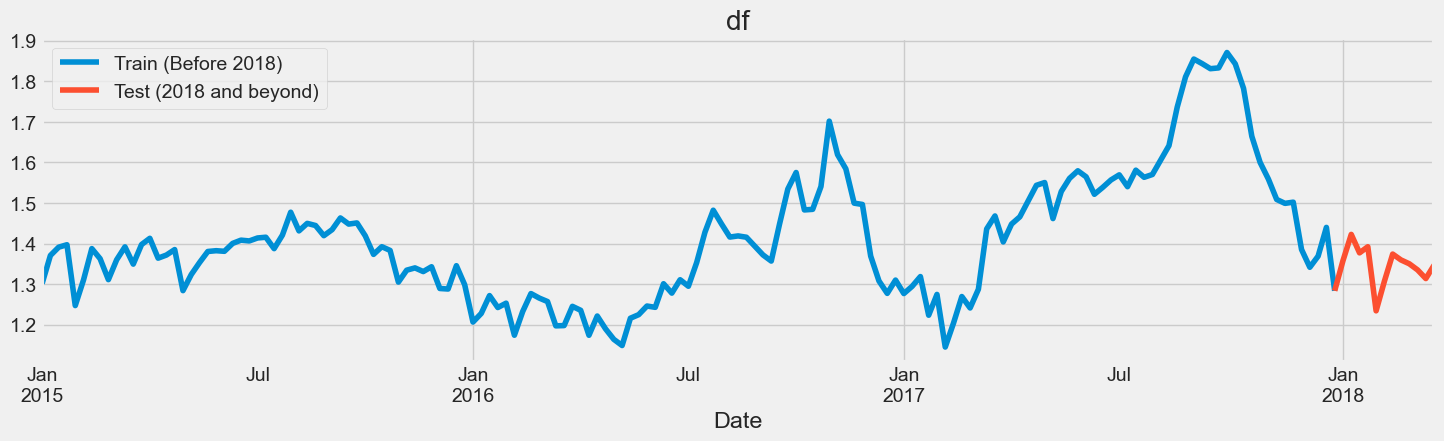

In [40]:
df.loc['2015-01-04':'2017-12-31', "AveragePrice"].plot(figsize=(16, 4), legend=True)
df.loc['2017-12-31':, "AveragePrice"].plot(figsize=(16, 4), legend=True)
plt.legend([f"Train (Before 2018)", f"Test (2018 and beyond)"])
plt.title("df")
plt.show()

LSTM is sensitive to the scale of the data so MinMaxScaler is applied.

In [41]:
df_scaled = df.copy()

In [42]:
scaler = MinMaxScaler(feature_range=(0,1))

In [43]:
cols_to_scale = ['Total_Volume', 'Total_Bags']

In [44]:
scaled_values = scaler.fit_transform(df[cols_to_scale])

In [45]:
df_scaled[cols_to_scale] = scaled_values

In [46]:
df_scaled

AveragePrice  Total_Volume  Total_Bags  season
Date                                                      
2015-01-04      1.301296      0.217639    0.178903       1
2015-01-11      1.370648      0.172843    0.086177       1
2015-01-18      1.391111      0.166191    0.125622       1
2015-01-25      1.397130      0.123561    0.133899       1
2015-02-01      1.247037      0.450064    0.240158       1
...                  ...           ...         ...     ...
2018-02-25      1.359630      0.828067    0.948330       1
2018-03-04      1.350185      0.858290    0.952701       2
2018-03-11      1.335093      0.898226    0.980696       2
2018-03-18      1.313704      0.911952    1.000000       2
2018-03-25      1.346852      0.896518    0.987752       2

[169 rows x 4 columns]

In [47]:
dates_array = df_scaled.index.to_numpy()

In [48]:
dates_array.shape

(169,)

In [49]:
dates_train = dates_array[3:] 
dates_train = dates_array[:154]
dates_test = dates_array[-12:]

In [50]:
dates_train.shape, dates_test.shape

((154,), (12,))

In [51]:
window_size = 3  # Number of observations used to predict the next one

# Create windows
X = []
y = []
for i in range(len(df_scaled['AveragePrice']) - window_size):
    X.append(df_scaled['AveragePrice'][i:i+window_size])
    y.append(df_scaled['AveragePrice'][i+window_size])

X = np.array(X)
y = np.array(y)

# X now contains sequences of 3 prices, and y contains the subsequent price
# Here you would split X and y into training and testing sets as needed

In [52]:
X, y

(array([[1.3012963 , 1.37064815, 1.39111111],
        [1.37064815, 1.39111111, 1.39712963],
        [1.39111111, 1.39712963, 1.24703704],
        [1.39712963, 1.24703704, 1.31046296],
        [1.24703704, 1.31046296, 1.38759259],
        [1.31046296, 1.38759259, 1.36268519],
        [1.38759259, 1.36268519, 1.31101852],
        [1.36268519, 1.31101852, 1.36009259],
        [1.31101852, 1.36009259, 1.39194444],
        [1.36009259, 1.39194444, 1.34925926],
        [1.39194444, 1.34925926, 1.39759259],
        [1.34925926, 1.39759259, 1.41296296],
        [1.39759259, 1.41296296, 1.36398148],
        [1.41296296, 1.36398148, 1.37166667],
        [1.36398148, 1.37166667, 1.38518519],
        [1.37166667, 1.38518519, 1.28388889],
        [1.38518519, 1.28388889, 1.32351852],
        [1.28388889, 1.32351852, 1.35314815],
        [1.32351852, 1.35314815, 1.38046296],
        [1.35314815, 1.38046296, 1.38240741],
        [1.38046296, 1.38240741, 1.38092593],
        [1.38240741, 1.38092593, 1

In [53]:
X.shape, y.shape

((166, 3), (166,))

In [54]:
features = ['Total_Bags', 'Total_Volume', 'season']
np_features = np.array(df[features])

In [55]:
np_features.shape

(169, 3)

In [56]:
np_features = np_features[3:, :] 

In [57]:
np_features.shape

(166, 3)

In [58]:
X_full = np.concatenate((X, np_features), axis=1)

In [59]:
X_full.shape

(166, 6)

In [60]:
X_train, y_train = X_full[:154], y[:154]

In [61]:
X_test, y_test = X_full[-12:], y[-12:]

In [62]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((154, 6), (154,), (12, 6), (12,))

In [63]:
X_test, y_test

(array([[ 1.36898148,  1.43990741,  1.28351852, 10.89954471, 11.68137186,
          1.        ],
        [ 1.43990741,  1.28351852,  1.35777778, 10.89958563, 11.66376781,
          1.        ],
        [ 1.28351852,  1.35777778,  1.42259259, 10.90570002, 11.6766592 ,
          1.        ],
        [ 1.35777778,  1.42259259,  1.37712963, 10.89191455, 11.6545197 ,
          1.        ],
        [ 1.42259259,  1.37712963,  1.39222222, 11.08365644, 11.88378479,
          1.        ],
        [ 1.37712963,  1.39222222,  1.23407407, 10.94855183, 11.67689393,
          1.        ],
        [ 1.39222222,  1.23407407,  1.30703704, 10.85843802, 11.64543075,
          1.        ],
        [ 1.23407407,  1.30703704,  1.37407407, 10.99452395, 11.6909944 ,
          1.        ],
        [ 1.30703704,  1.37407407,  1.35962963, 11.00338418, 11.72488337,
          2.        ],
        [ 1.37407407,  1.35962963,  1.35018519, 11.06014055, 11.76966416,
          2.        ],
        [ 1.35962963,  1.35018

In [64]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#### **LSTM Model (for exact price)**

In [65]:
#This model is designed for a sequence prediction task, where you're predicting a single value from sequences of length 6
#Sequential: This initiates a linear stack of layers, allowing you to create the model layer by layer.
LSTM_model = Sequential([layers.Input((6, 1)),#Specifies the input shape to the model, indicating that each input sequence has 6 time steps, each with 1 feature.
                    layers.LSTM(64),#Adds an LSTM layer with 64 units. LSTM layers are useful for sequence prediction problems because they can maintain long-term dependencies in sequence data.
                    layers.Dense(32, activation='relu'),#Adds a fully connected (Dense) layer with 32 neurons and ReLU activation. 
                    layers.Dense(32, activation='relu'),#This is a common choice for hidden layers in neural networks to further process the data.
                    layers.Dense(1)])#Adds the output layer with a single neuron, as you're predicting a single value. By default, a Dense layer uses a linear activation function, which is suitable for regression tasks.

LSTM_model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

LSTM_model.fit(X_train, y_train, epochs=100)
#An epoch is one complete pass through the entire training dataset.

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.7027 - mean_absolute_error: 1.2905
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8257 - mean_absolute_error: 0.8926 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2920 - mean_absolute_error: 0.5183 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0425 - mean_absolute_error: 0.1631 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0780 - mean_absolute_error: 0.2581 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0834 - mean_absolute_error: 0.2684 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 - mean_absolute_error: 0.1409 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mean_absolute_error: 0.1122 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0275 - mean_absolute_error: 0.1239 
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - mean_absolute_error: 0.1159 
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

In [66]:
#This model is designed for a sequence prediction task, where you're predicting a single value from sequences of length 6
#Sequential: This initiates a linear stack of layers, allowing you to create the model layer by layer.
LSTM_model2 = Sequential([layers.Input((6, 1)),#Specifies the input shape to the model, indicating that each input sequence has 6 time steps, each with 1 feature.
                    layers.LSTM(128, return_sequences=True),#Adds an LSTM layer with 64 units. LSTM layers are useful for sequence prediction problems because they can maintain long-term dependencies in sequence data.
                    layers.LSTM(64),#Adds a fully connected (Dense) layer with 32 neurons and ReLU activation. 
                    layers.Dense(32, activation='relu'),#This is a common choice for hidden layers in neural networks to further process the data.
                    layers.Dense(1)])#Adds the output layer with a single neuron, as you're predicting a single value. By default, a Dense layer uses a linear activation function, which is suitable for regression tasks.

LSTM_model2.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error', 'accuracy'])

LSTM_model2.fit(X_train, y_train, epochs=100)
#An epoch is one complete pass through the entire training dataset.

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0000e+00 - loss: 1.1122 - mean_absolute_error: 1.0292
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0977 - mean_absolute_error: 0.2689 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.1376 - mean_absolute_error: 0.3491 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0233 - mean_absolute_error: 0.1193 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0556 - mean_absolute_error: 0.1989 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0201 - mean_absolute_error: 0.1029 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0231 - mean_absolute_error: 0.1268 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0237 - mean_absolute_error: 0.1284 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accura

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


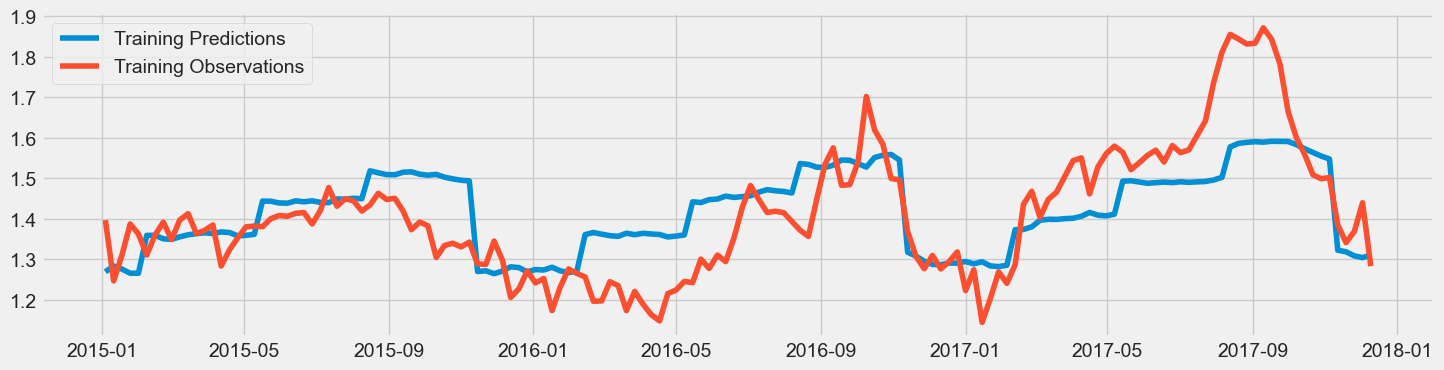

In [67]:
LSTM_train_predictions = LSTM_model.predict(X_train).flatten()

plt.figure(figsize=(16, 4))
plt.plot(dates_train, LSTM_train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


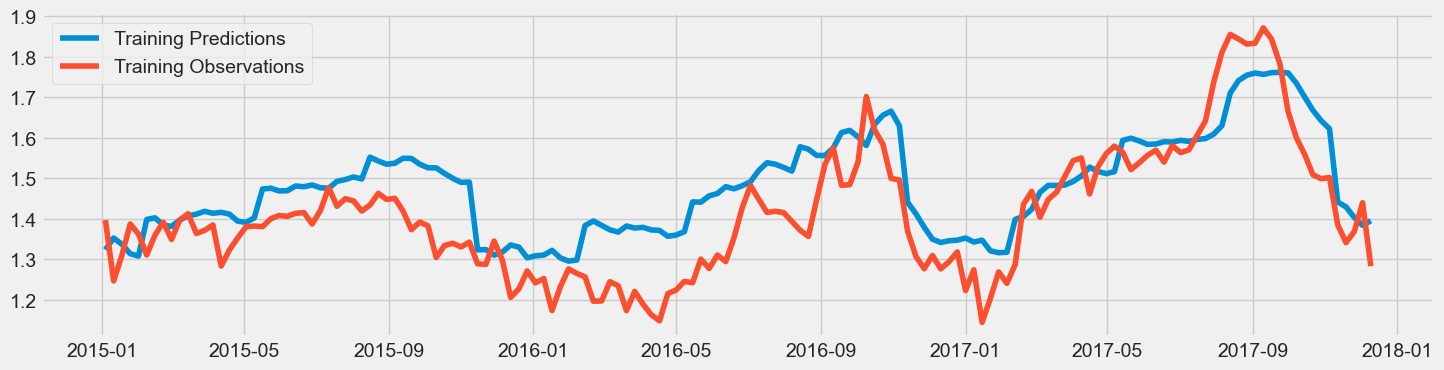

In [68]:
LSTM_train_predictions2 = LSTM_model2.predict(X_train).flatten()

plt.figure(figsize=(16, 4))
plt.plot(dates_train, LSTM_train_predictions2)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


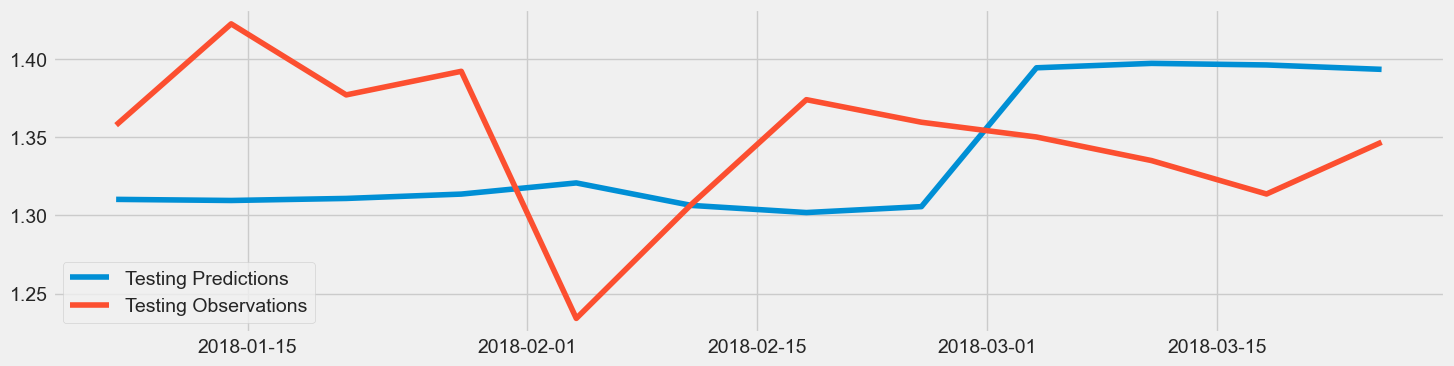

In [69]:
LSTM_test_predictions = LSTM_model.predict(X_test).flatten()

plt.figure(figsize=(16, 4))
plt.plot(dates_test, LSTM_test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


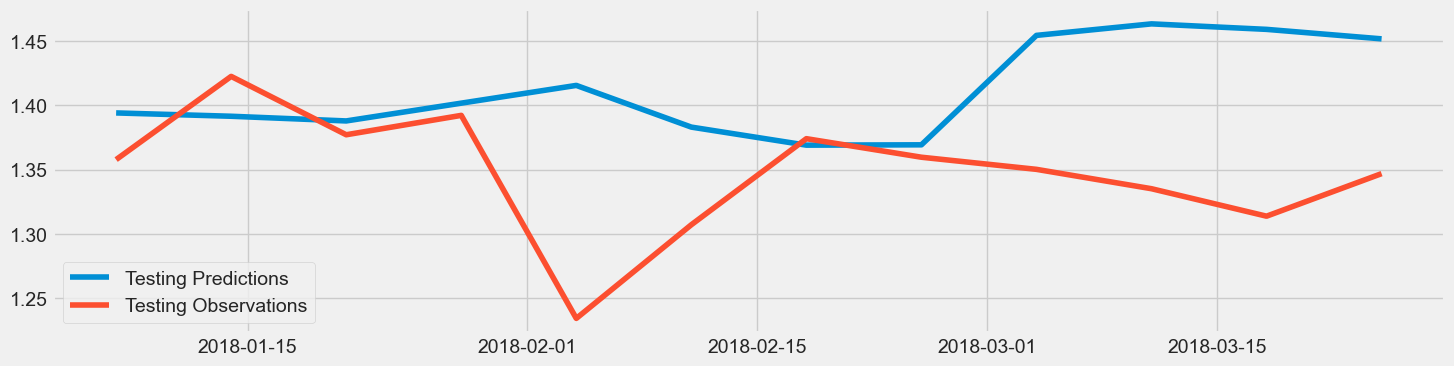

In [70]:
LSTM_test_predictions2 = LSTM_model2.predict(X_test).flatten()

plt.figure(figsize=(16, 4))
plt.plot(dates_test, LSTM_test_predictions2)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

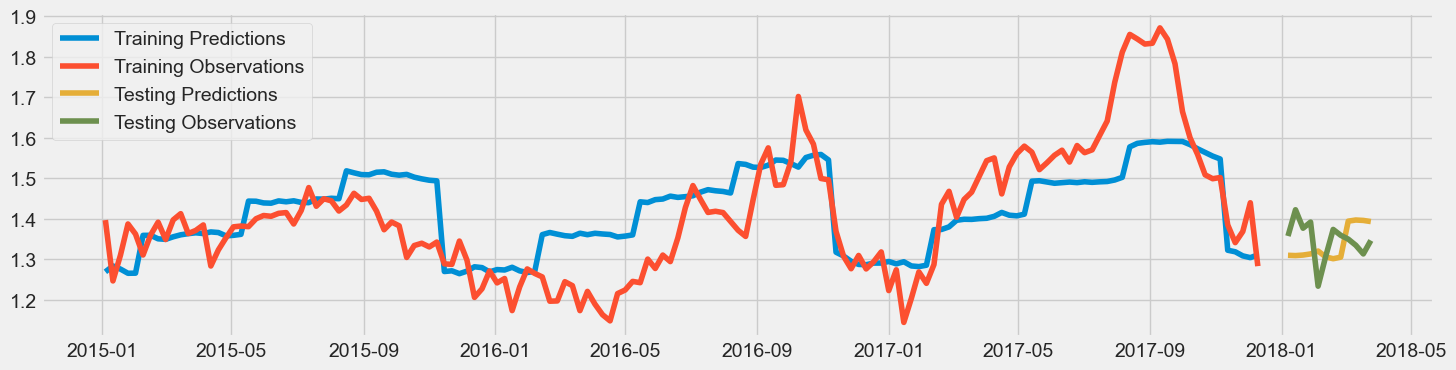

In [71]:
plt.figure(figsize=(16, 4))
plt.plot(dates_train, LSTM_train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_test, LSTM_test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Testing Predictions', 
            'Testing Observations'])

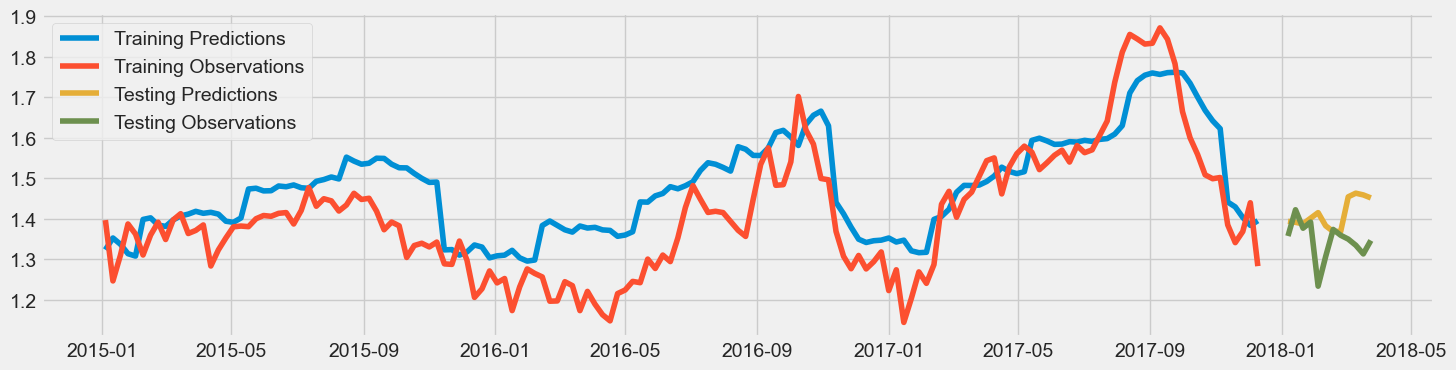

In [72]:
plt.figure(figsize=(16, 4))
plt.plot(dates_train, LSTM_train_predictions2)
plt.plot(dates_train, y_train)
plt.plot(dates_test, LSTM_test_predictions2)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Testing Predictions', 
            'Testing Observations'])

#### It's hard to predict the exact price, so let's try to predict only the direction of the movement of price.

In [73]:
df_scaled2 = df_scaled.copy()

In [74]:
df_scaled2

AveragePrice  Total_Volume  Total_Bags  season
Date                                                      
2015-01-04      1.301296      0.217639    0.178903       1
2015-01-11      1.370648      0.172843    0.086177       1
2015-01-18      1.391111      0.166191    0.125622       1
2015-01-25      1.397130      0.123561    0.133899       1
2015-02-01      1.247037      0.450064    0.240158       1
...                  ...           ...         ...     ...
2018-02-25      1.359630      0.828067    0.948330       1
2018-03-04      1.350185      0.858290    0.952701       2
2018-03-11      1.335093      0.898226    0.980696       2
2018-03-18      1.313704      0.911952    1.000000       2
2018-03-25      1.346852      0.896518    0.987752       2

[169 rows x 4 columns]

In [75]:
df_scaled2["Next_week"] = df_scaled2["AveragePrice"].shift(-1)

In [76]:
df_scaled2

AveragePrice  Total_Volume  Total_Bags  season  Next_week
Date                                                                 
2015-01-04      1.301296      0.217639    0.178903       1   1.370648
2015-01-11      1.370648      0.172843    0.086177       1   1.391111
2015-01-18      1.391111      0.166191    0.125622       1   1.397130
2015-01-25      1.397130      0.123561    0.133899       1   1.247037
2015-02-01      1.247037      0.450064    0.240158       1   1.310463
...                  ...           ...         ...     ...        ...
2018-02-25      1.359630      0.828067    0.948330       1   1.350185
2018-03-04      1.350185      0.858290    0.952701       2   1.335093
2018-03-11      1.335093      0.898226    0.980696       2   1.313704
2018-03-18      1.313704      0.911952    1.000000       2   1.346852
2018-03-25      1.346852      0.896518    0.987752       2        NaN

[169 rows x 5 columns]

In [77]:
df_scaled2["Target"] = (df_scaled2["Next_week"] > df_scaled2["AveragePrice"]).astype(int)

In [78]:
df_scaled2

AveragePrice  Total_Volume  Total_Bags  season  Next_week  Target
Date                                                                         
2015-01-04      1.301296      0.217639    0.178903       1   1.370648       1
2015-01-11      1.370648      0.172843    0.086177       1   1.391111       1
2015-01-18      1.391111      0.166191    0.125622       1   1.397130       1
2015-01-25      1.397130      0.123561    0.133899       1   1.247037       0
2015-02-01      1.247037      0.450064    0.240158       1   1.310463       1
...                  ...           ...         ...     ...        ...     ...
2018-02-25      1.359630      0.828067    0.948330       1   1.350185       0
2018-03-04      1.350185      0.858290    0.952701       2   1.335093       0
2018-03-11      1.335093      0.898226    0.980696       2   1.313704       0
2018-03-18      1.313704      0.911952    1.000000       2   1.346852       1
2018-03-25      1.346852      0.896518    0.987752       2        NaN       0

[169 rows x 6 columns]

In [79]:
df_scaled2.isnull().any() #to check if there are any missing values.

AveragePrice    False
Total_Volume    False
Total_Bags      False
season          False
Next_week        True
Target          False
dtype: bool

In [80]:
df_scaled2.duplicated().any() #to check if there are duplicated values.

False

In [81]:
df_scaled2.describe()  # Pulls out the objects dtypes attributes and shows their count/frequency/max/quartiles.

AveragePrice  Total_Volume  Total_Bags      season   Next_week  \
count    169.000000    169.000000  169.000000  169.000000  168.000000   
mean       1.405988      0.493985    0.550588    2.414201    1.406611   
std        0.151713      0.208158    0.266154    1.126007    0.151949   
min        1.144722      0.000000    0.000000    1.000000    1.144722   
25%        1.300926      0.341857    0.247242    1.000000    1.300301   
50%        1.385185      0.512419    0.638543    2.000000    1.385278   
75%        1.482315      0.654084    0.760257    3.000000    1.482477   
max        1.871296      1.000000    1.000000    4.000000    1.871296   

           Target  
count  169.000000  
mean     0.538462  
std      0.500000  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      1.000000  
max      1.000000

In [82]:
df_scaled2["Target"].value_counts()

Target
1    91
0    78
Name: count, dtype: int64

### **Models for Price Direction**

#### **RandomForest Model I**

In [83]:
train = df_scaled2.iloc[:135]
test = df_scaled2.iloc[-34:]

In [84]:
train.shape, test.shape

((135, 6), (34, 6))

In [85]:
train["Target"].value_counts(), test["Target"].value_counts(),

(Target
 1    76
 0    59
 Name: count, dtype: int64,
 Target
 0    19
 1    15
 Name: count, dtype: int64)

In [86]:
RandomForest_model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)
#n_estimators: number of decisions trees we want to train.
#min_sample_split: if decisions trees build the tree too deeply they tend to overfit. This min_sample_split helps to avoid that. what's the optimal number?
#random_state=1: If we run the model twice, we get the same results.
#In timeseries you cannot use cross validation because the time dependency of the observations.

predictors = ["AveragePrice", "Total_Volume", "Total_Bags", "season"]
RandomForest_model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [87]:
preds = pd.Series(RandomForest_model.predict(test[predictors]), index=test.index)

Precision

In [88]:
precision_score(test["Target"], preds)

0.4411764705882353

In [89]:
preds.value_counts()

1    34
Name: count, dtype: int64

Enable Backtesting

In [90]:
def predict1(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = pd.Series(model.predict(test[predictors]), index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined 


In [91]:
def backtest1(data, model, predictors, start=100, step=5):
#start: the amount of data to train the first model
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict1(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [92]:
RandomForest_predictions = backtest1(df_scaled2, RandomForest_model, predictors)

In [93]:
RandomForest_predictions["Predictions"].value_counts()

Predictions
1    69
Name: count, dtype: int64

In [94]:
precision_score(RandomForest_predictions["Target"], RandomForest_predictions["Predictions"])

0.5507246376811594

In [95]:
RandomForest_predictions["Target"].value_counts() / RandomForest_predictions.shape[0]

Target
1    0.550725
0    0.449275
Name: count, dtype: float64

#### **RandomForest Model II**

In [96]:
horizons = [2,5,10]
new_predictors = []

for horizon in horizons:
    rolling_averages = df_scaled2.rolling(horizon).mean()
    
    #ratio between today's price and the average of the price (horizon) days ago.
    ratio_column = f"Price_Ratio_{horizon}"
    df_scaled2[ratio_column] = df_scaled2["AveragePrice"] / rolling_averages["AveragePrice"]
    

    #number of days in the past (horizon) days that the price went up.
    trend_column = f"Trend_{horizon}"
    df_scaled2[trend_column] = df_scaled2.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= ["AveragePrice", ratio_column, trend_column]

In [97]:
new_predictors

['AveragePrice',
 'Price_Ratio_2',
 'Trend_2',
 'AveragePrice',
 'Price_Ratio_5',
 'Trend_5',
 'AveragePrice',
 'Price_Ratio_10',
 'Trend_10']

In [98]:
avocado = df_scaled2.dropna(subset=df_scaled2.columns[df_scaled2.columns != "Next_week"])

In [99]:
avocado

AveragePrice  Total_Volume  Total_Bags  season  Next_week  Target  \
Date                                                                            
2015-03-15      1.391944      0.185791    0.108330       2   1.349259       0   
2015-03-22      1.349259      0.260187    0.000000       2   1.397593       1   
2015-03-29      1.397593      0.238888    0.127820       2   1.412963       1   
2015-04-05      1.412963      0.275746    0.181389       2   1.363981       0   
2015-04-12      1.363981      0.344598    0.184168       2   1.371667       1   
...                  ...           ...         ...     ...        ...     ...   
2018-02-25      1.359630      0.828067    0.948330       1   1.350185       0   
2018-03-04      1.350185      0.858290    0.952701       2   1.335093       0   
2018-03-11      1.335093      0.898226    0.980696       2   1.313704       0   
2018-03-18      1.313704      0.911952    1.000000       2   1.346852       1   
2018-03-25      1.346852      0.896518    0.987752       2        NaN       0   

            Price_Ratio_2  Trend_2  Price_Ratio_5  Trend_5  Price_Ratio_10  \
Date                                                                         
2015-03-15       1.011574      2.0       1.021486      3.0        1.028805   
2015-03-22       0.984428      1.0       0.995763      2.0        0.998835   
2015-03-29       1.017596      1.0       1.026147      3.0        1.034119   
2015-04-05       1.005469      2.0       1.022131      4.0        1.044268   
2015-04-12       0.982361      1.0       0.986143      3.0        0.999430   
...                   ...      ...            ...      ...             ...   
2018-02-25       0.994716      1.0       1.019666      3.0        1.003568   
2018-03-04       0.996515      0.0       1.019008      2.0        1.003240   
2018-03-11       0.994380      0.0       0.992484      2.0        0.988239   
2018-03-18       0.991925      0.0       0.975616      1.0        0.975590   
2018-03-25       1.012459      1.0       1.004294      1.0        1.005864   

            Trend_10  
Date                  
2015-03-15       7.0  
2015-03-22       6.0  
2015-03-29       6.0  
2015-04-05       6.0  
2015-04-12       6.0  
...              ...  
2018-02-25       6.0  
2018-03-04       5.0  
2018-03-11       5.0  
2018-03-18       4.0  
2018-03-25       4.0  

[159 rows x 12 columns]

In [118]:
avocado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 159 entries, 2015-03-15 to 2018-03-25
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AveragePrice    159 non-null    float64
 1   Total_Volume    159 non-null    float64
 2   Total_Bags      159 non-null    float64
 3   season          159 non-null    int32  
 4   Next_week       158 non-null    float64
 5   Target          159 non-null    int32  
 6   Price_Ratio_2   159 non-null    float64
 7   Trend_2         159 non-null    float64
 8   Price_Ratio_5   159 non-null    float64
 9   Trend_5         159 non-null    float64
 10  Price_Ratio_10  159 non-null    float64
 11  Trend_10        159 non-null    float64
dtypes: float64(10), int32(2)
memory usage: 14.9 KB


<Axes: title={'center': 'Correlation Matrix'}>

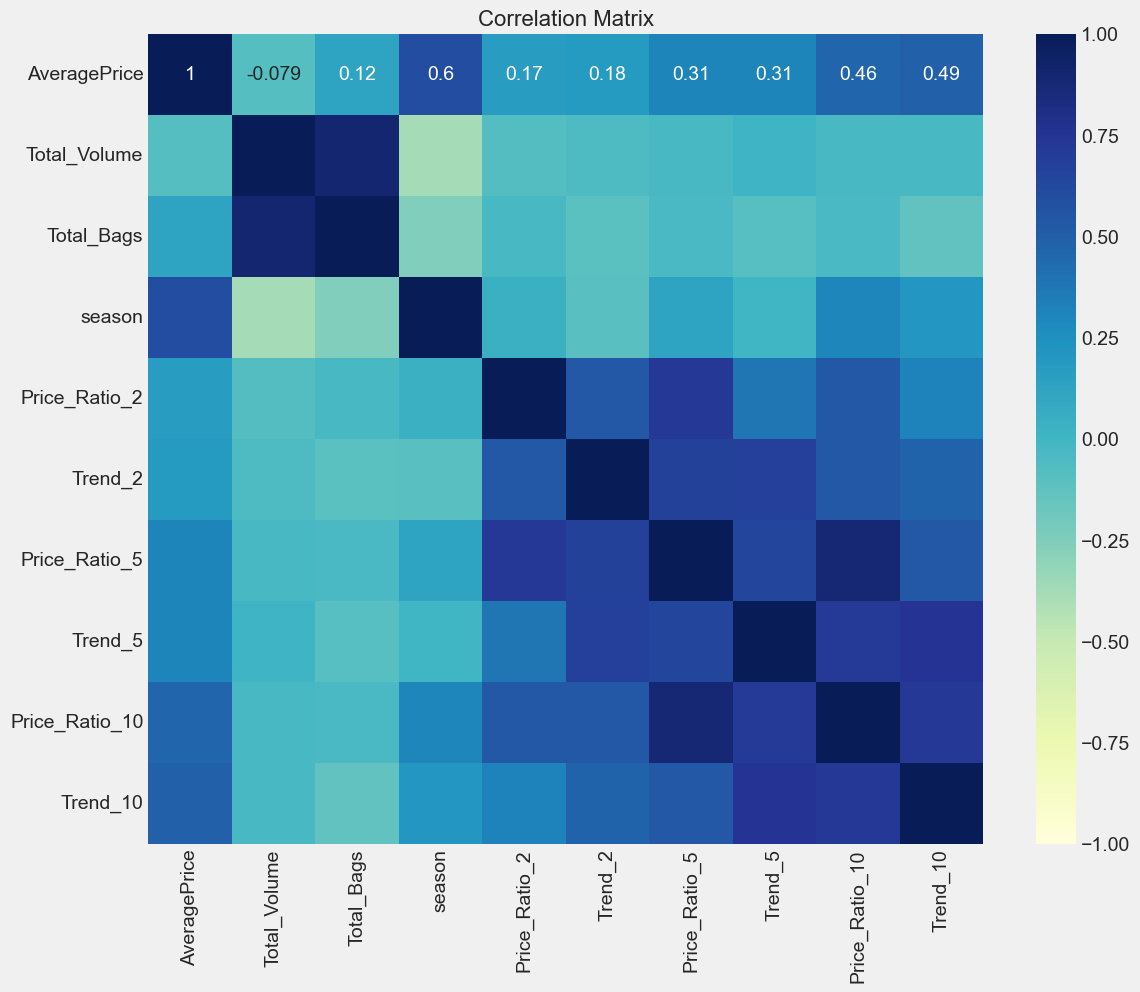

In [100]:
corr = avocado.drop(['Next_week', 'Target'], axis=1).corr()
corr

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
ax.set_title('Correlation Matrix', fontsize=16)

sns.heatmap(corr, vmin=-1, vmax=1, cmap='YlGnBu', annot=True)

In [101]:
RandomForest_model2 = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [102]:
def predict2(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    #the 2 lines above define a threshold so the model is 60% confident that the price will go up.
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [103]:
def backtest2(data, model, predictors, start=100, step=5):
#start: the amount of data to train the first model
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict2(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [104]:
RandomForest_predictions2 = backtest2(avocado, RandomForest_model2, new_predictors)

In [105]:
RandomForest_predictions2["Predictions"].value_counts()

Predictions
0.0    49
1.0    10
Name: count, dtype: int64

In [106]:
precision_score(RandomForest_predictions2["Target"], RandomForest_predictions2["Predictions"])

0.6

In [107]:

RandomForest_predictions2["Target"].value_counts() / RandomForest_predictions2.shape[0]

Target
1    0.559322
0    0.440678
Name: count, dtype: float64

In [108]:
RandomForest_predictions2

Target  Predictions
Date                           
2017-02-12       1          1.0
2017-02-19       0          0.0
2017-02-26       1          0.0
2017-03-05       1          0.0
2017-03-12       1          0.0
2017-03-19       0          0.0
2017-03-26       1          0.0
2017-04-02       1          0.0
2017-04-09       1          0.0
2017-04-16       1          0.0
2017-04-23       1          0.0
2017-04-30       0          0.0
2017-05-07       1          0.0
2017-05-14       1          0.0
2017-05-21       1          0.0
2017-05-28       0          0.0
2017-06-04       0          0.0
2017-06-11       1          1.0
2017-06-18       1          0.0
2017-06-25       1          0.0
2017-07-02       0          0.0
2017-07-09       1          1.0
2017-07-16       0          0.0
2017-07-23       1          0.0
2017-07-30       1          0.0
2017-08-06       1          0.0
2017-08-13       1          0.0
2017-08-20       1          0.0
2017-08-27       1          0.0
2017-09-03       0          0.0
2017-09-10       0          0.0
2017-09-17       1          0.0
2017-09-24       1          0.0
2017-10-01       0          0.0
2017-10-08       0          0.0
2017-10-15       0          0.0
2017-10-22       0          1.0
2017-10-29       0          0.0
2017-11-05       0          1.0
2017-11-12       0          1.0
2017-11-19       1          0.0
2017-11-26       0          0.0
2017-12-03       0          0.0
2017-12-10       1          0.0
2017-12-17       1          0.0
2017-12-24       0          0.0
2017-12-31       1          0.0
2018-01-07       1          1.0
2018-01-14       0          0.0
2018-01-21       1          0.0
2018-01-28       0          0.0
2018-02-04       1          1.0
2018-02-11       1          1.0
2018-02-18       0          0.0
2018-02-25       0          0.0
2018-03-04       0          0.0
2018-03-11       0          1.0
2018-03-18       1          0.0
2018-03-25       0          0.0

In [109]:
RandomForest_predictions2["Target"].value_counts(), RandomForest_predictions2["Predictions"].value_counts()

(Target
 1    33
 0    26
 Name: count, dtype: int64,
 Predictions
 0.0    49
 1.0    10
 Name: count, dtype: int64)

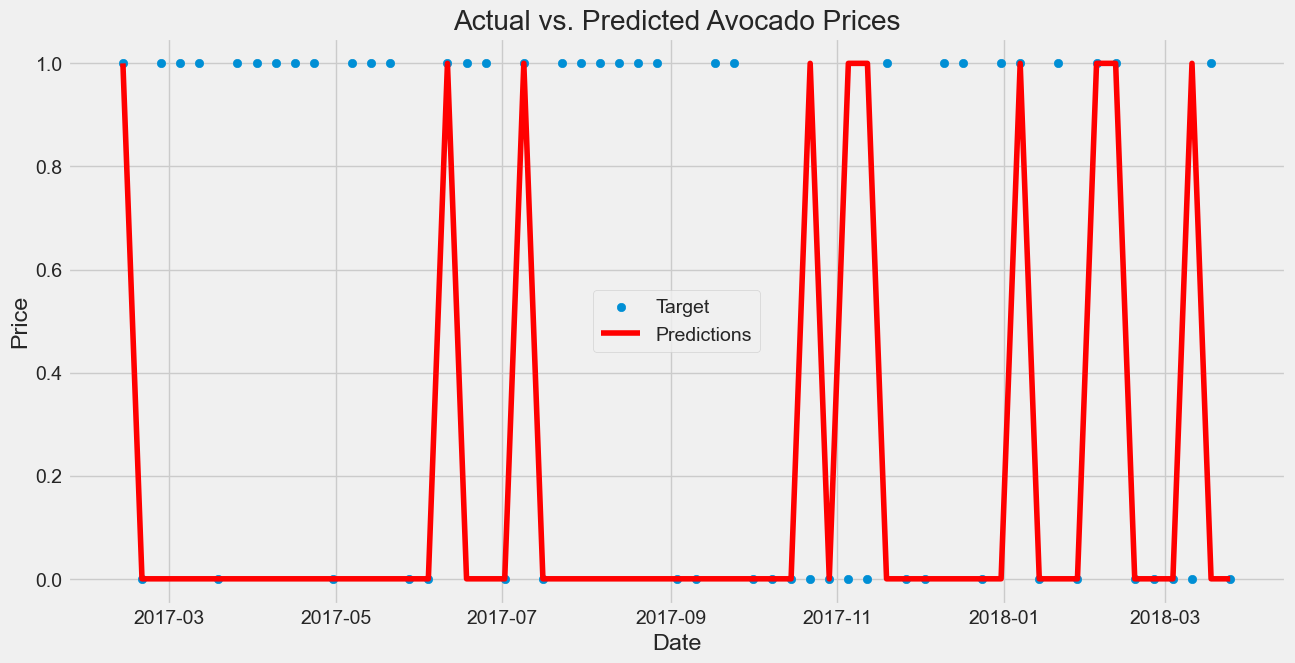

In [110]:
plt.figure(figsize=(14, 7))

# Line plot for Actual values
plt.scatter(RandomForest_predictions2.index, RandomForest_predictions2['Target'], label='Target', marker='o', linestyle='-')

# Scatter plot for Predictions
plt.plot(RandomForest_predictions2.index, RandomForest_predictions2['Predictions'], color='red', label='Predictions')

plt.title('Actual vs. Predicted Avocado Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [111]:
RandomForest_predictions_final = pd.concat([avocado["AveragePrice"], RandomForest_predictions2], axis=1).dropna()

In [112]:
RandomForest_predictions_final.head()

AveragePrice  Target  Predictions
Date                                         
2017-02-12      1.203981     1.0          1.0
2017-02-19      1.269352     0.0          0.0
2017-02-26      1.241111     1.0          0.0
2017-03-05      1.287407     1.0          0.0
2017-03-12      1.436111     1.0          0.0

In [113]:
# Shift the Opening Price by 1 to align the selling price with the buying day
RandomForest_predictions_final['Next_week'] = RandomForest_predictions_final['AveragePrice'].shift(-1)

# Calculate profit for days where the model predicts an increase
# Profit = Next day's opening (selling price) - Today's opening (buying price)
RandomForest_predictions_final['Profit'] = np.where(RandomForest_predictions_final['Predictions'] == 1, 
                                            RandomForest_predictions_final['Next_week']*100 - RandomForest_predictions_final['AveragePrice']*100, 
                                            0)

# Calculate total profit
RandomForest_total_profit = RandomForest_predictions_final['Profit'].sum()

RandomForest_total_profit

18.22083766008994

In [114]:
RandomForest_predictions_final

AveragePrice  Target  Predictions  Next_week    Profit
Date                                                              
2017-02-12      1.203981     1.0          1.0   1.269352  6.537037
2017-02-19      1.269352     0.0          0.0   1.241111  0.000000
2017-02-26      1.241111     1.0          0.0   1.287407  0.000000
2017-03-05      1.287407     1.0          0.0   1.436111  0.000000
2017-03-12      1.436111     1.0          0.0   1.468148  0.000000
2017-03-19      1.468148     0.0          0.0   1.404074  0.000000
2017-03-26      1.404074     1.0          0.0   1.448056  0.000000
2017-04-02      1.448056     1.0          0.0   1.465926  0.000000
2017-04-09      1.465926     1.0          0.0   1.504815  0.000000
2017-04-16      1.504815     1.0          0.0   1.543704  0.000000
2017-04-23      1.543704     1.0          0.0   1.550556  0.000000
2017-04-30      1.550556     0.0          0.0   1.461667  0.000000
2017-05-07      1.461667     1.0          0.0   1.528333  0.000000
2017-05-14      1.528333     1.0          0.0   1.560833  0.000000
2017-05-21      1.560833     1.0          0.0   1.579537  0.000000
2017-05-28      1.579537     0.0          0.0   1.564630  0.000000
2017-06-04      1.564630     0.0          0.0   1.521574  0.000000
2017-06-11      1.521574     1.0          1.0   1.538505  1.693060
2017-06-18      1.538505     1.0          0.0   1.556916  0.000000
2017-06-25      1.556916     1.0          0.0   1.569537  0.000000
2017-07-02      1.569537     0.0          0.0   1.540278  0.000000
2017-07-09      1.540278     1.0          1.0   1.581019  4.074074
2017-07-16      1.581019     0.0          0.0   1.563426  0.000000
2017-07-23      1.563426     1.0          0.0   1.570370  0.000000
2017-07-30      1.570370     1.0          0.0   1.606204  0.000000
2017-08-06      1.606204     1.0          0.0   1.641574  0.000000
2017-08-13      1.641574     1.0          0.0   1.736852  0.000000
2017-08-20      1.736852     1.0          0.0   1.811204  0.000000
2017-08-27      1.811204     1.0          0.0   1.855185  0.000000
2017-09-03      1.855185     0.0          0.0   1.843889  0.000000
2017-09-10      1.843889     0.0          0.0   1.831389  0.000000
2017-09-17      1.831389     1.0          0.0   1.833333  0.000000
2017-09-24      1.833333     1.0          0.0   1.871296  0.000000
2017-10-01      1.871296     0.0          0.0   1.843333  0.000000
2017-10-08      1.843333     0.0          0.0   1.782870  0.000000
2017-10-15      1.782870     0.0          0.0   1.664537  0.000000
2017-10-22      1.664537     0.0          1.0   1.600185 -6.435185
2017-10-29      1.600185     0.0          0.0   1.559074  0.000000
2017-11-05      1.559074     0.0          1.0   1.508796 -5.027778
2017-11-12      1.508796     0.0          1.0   1.499167 -0.962963
2017-11-19      1.499167     1.0          0.0   1.502130  0.000000
2017-11-26      1.502130     0.0          0.0   1.385370  0.000000
2017-12-03      1.385370     0.0          0.0   1.341481  0.000000
2017-12-10      1.341481     1.0          0.0   1.368981  0.000000
2017-12-17      1.368981     1.0          0.0   1.439907  0.000000
2017-12-24      1.439907     0.0          0.0   1.283519  0.000000
2017-12-31      1.283519     1.0          0.0   1.357778  0.000000
2018-01-07      1.357778     1.0          1.0   1.422593  6.481481
2018-01-14      1.422593     0.0          0.0   1.377130  0.000000
2018-01-21      1.377130     1.0          0.0   1.392222  0.000000
2018-01-28      1.392222     0.0          0.0   1.234074  0.000000
2018-02-04      1.234074     1.0          1.0   1.307037  7.296296
2018-02-11      1.307037     1.0          1.0   1.374074  6.703704
2018-02-18      1.374074     0.0          0.0   1.359630  0.000000
2018-02-25      1.359630     0.0          0.0   1.350185  0.000000
2018-03-04      1.350185     0.0          0.0   1.335093  0.000000
2018-03-11      1.335093     0.0          1.0   1.313704 -2.138889
2018-03-18      1.313704     1.0          0.0   1.346852  0

#### **XGBoost Model**

In [115]:
new_predictors = ['AveragePrice','Price_Ratio_2','Trend_2','Price_Ratio_5','Trend_5','Price_Ratio_10','Trend_10']

In [116]:
XGB_model = XGBClassifier(random_state=1, learning_rate=.1, n_estimators=200)
#the lower the learning rate, the lower the chance to overfit.
XGB_predictions = backtest2(avocado, XGB_model, new_predictors)

In [117]:
XGB_predictions["Target"].value_counts(), XGB_predictions["Predictions"].value_counts()

(Target
 1    33
 0    26
 Name: count, dtype: int64,
 Predictions
 0.0    40
 1.0    19
 Name: count, dtype: int64)

In [86]:
precision_score(XGB_predictions["Target"], XGB_predictions["Predictions"])

0.7368421052631579

In [87]:
XGB_predictions_final = pd.concat([avocado["AveragePrice"], XGB_predictions], axis=1).dropna()

In [88]:
# Shift the Opening Price by 1 to align the selling price with the buying day
XGB_predictions_final['Next_week'] = XGB_predictions_final['AveragePrice'].shift(-1)

# Calculate profit for days where the model predicts an increase
# Profit = Next day's opening (selling price) - Today's opening (buying price)
XGB_predictions_final['Profit'] = np.where(XGB_predictions_final['Predictions'] == 1, 
                                            XGB_predictions_final['Next_week']*100 - XGB_predictions_final['AveragePrice']*100, 
                                            0)

# Calculate total profit
XGB_total_profit = XGB_predictions_final['Profit'].sum()

XGB_total_profit

53.69158878504675

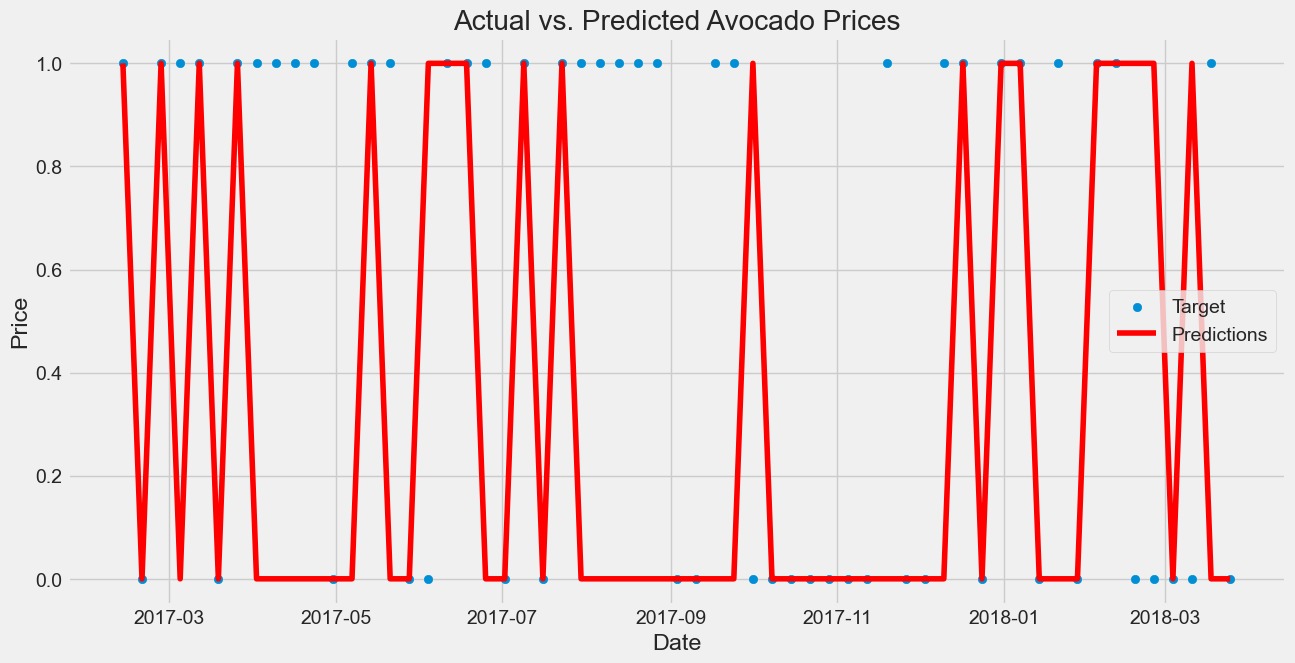

In [89]:
plt.figure(figsize=(14, 7))

# Line plot for Actual values
plt.scatter(XGB_predictions.index, XGB_predictions['Target'], label='Target', marker='o', linestyle='-')

# Scatter plot for Predictions
plt.plot(XGB_predictions.index, XGB_predictions['Predictions'], color='red', label='Predictions')

plt.title('Actual vs. Predicted Avocado Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

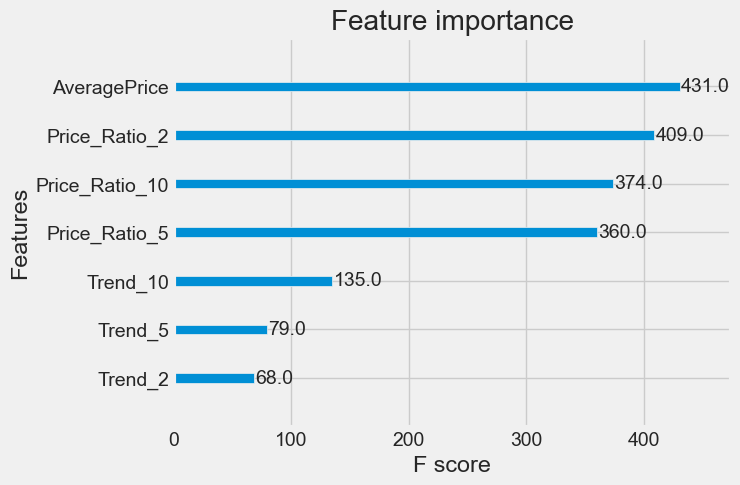

In [90]:
xgb.plot_importance(XGB_model)
plt.show()

In [612]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [613]:
classifier = xgboost.XGBClassifier()

In [614]:
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='accuracy',n_jobs=-1,verbose=3)

In [615]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [616]:
Y = avocado[['Target']]
X = avocado[["AveragePrice", "Total_Bags", "Total_Volume", "season",'Price_Ratio_2','Trend_2','Price_Ratio_5','Trend_5','Price_Ratio_10','Trend_10']]
Y = Y.iloc[0:100]
X = X.iloc[0:100]

X.shape, Y.shape

((100, 10), (100, 1))

In [617]:
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X,Y)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Time taken: 0 hours 0 minutes and 3.83 seconds.


In [618]:
random_search.best_estimator_, random_search.best_params_

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.3, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.0, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.25, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 {'min_child_weight': 1,
  'max_depth': 5,
  'learning_rate': 0.25,
  'gamma': 0.0,
  'colsample_bytree': 0.3})

#### **LSTM**

In [353]:
LSTM_features = avocado.copy()
LSTM_features = LSTM_features.drop('Target', axis=1)
LSTM_features = list(LSTM_features.columns)
LSTM_np_features = np.array(avocado[LSTM_features])
y = np.array(avocado['Target'])

In [354]:
LSTM_np_features.shape, y.shape

((159, 11), (159,), (159, 12))

In [355]:
X_train, y_train = LSTM_np_features[:135], y[:135]
X_test, y_test = LSTM_np_features[-34:], y[-34:]
dates_train = dates_array[:135]
dates_test = dates_array[-34:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((135, 11), (135,), (34, 11), (34,))

In [356]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [357]:
#This model is designed for a sequence prediction task, where you're predicting a single value from sequences of length 11
#Sequential: This initiates a linear stack of layers, allowing you to create the model layer by layer.
LSTM_model3 = Sequential([
                            layers.Input(shape=(11, 1)),
                            layers.LSTM(128, return_sequences=True),
                            layers.LeakyReLU(alpha=0.01),
                            layers.BatchNormalization(),  # Adding batch normalization
                            layers.LSTM(64, return_sequences=True),
                            layers.Dropout(0.2),  # Adding dropout for regularization
                            layers.LSTM(32),
                            layers.Dense(32, kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
                            layers.LeakyReLU(alpha=0.01),
                            layers.Dense(1, activation='sigmoid')
                        ])

LSTM_model3.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [358]:
LSTM_model3.fit(X_train, y_train, epochs=100)
#An epoch is one complete pass through the entire training dataset.

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4954 - loss: 1.0098
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5398 - loss: 0.9877 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5541 - loss: 0.9744 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5609 - loss: 0.9594 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5996 - loss: 0.9418 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5909 - loss: 0.9170 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5934 - loss: 0.9182 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5825 - loss: 0.9030 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5376 - loss: 0.9106 
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5304 - loss: 0.8971 
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6068 - loss: 0.8703 
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6384 - loss

In [359]:
preds = LSTM_model3.predict(X_test).flatten()
preds[preds >=.6] = 1
preds[preds <.6] = 0
#the 2 lines above define a threshold so the model is 60% confident that the price will go up.
preds

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step


array([ 1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1., nan], dtype=float32)

In [360]:
LSTM_preds = pd.DataFrame(preds, columns=['Predictions'])
actuals = pd.DataFrame(y_test, columns=['Target'])
LSTM_results = pd.concat([LSTM_preds, actuals], axis=1)
LSTM_results.index = dates_test
LSTM_results = LSTM_results.dropna()

In [361]:
LSTM_results["Target"].value_counts(), LSTM_results["Predictions"].value_counts()

(Target
 0    18
 1    15
 Name: count, dtype: int64,
 Predictions
 1.0    24
 0.0     9
 Name: count, dtype: int64)

In [362]:
precision_score(LSTM_results["Target"], LSTM_results["Predictions"])

0.5416666666666666

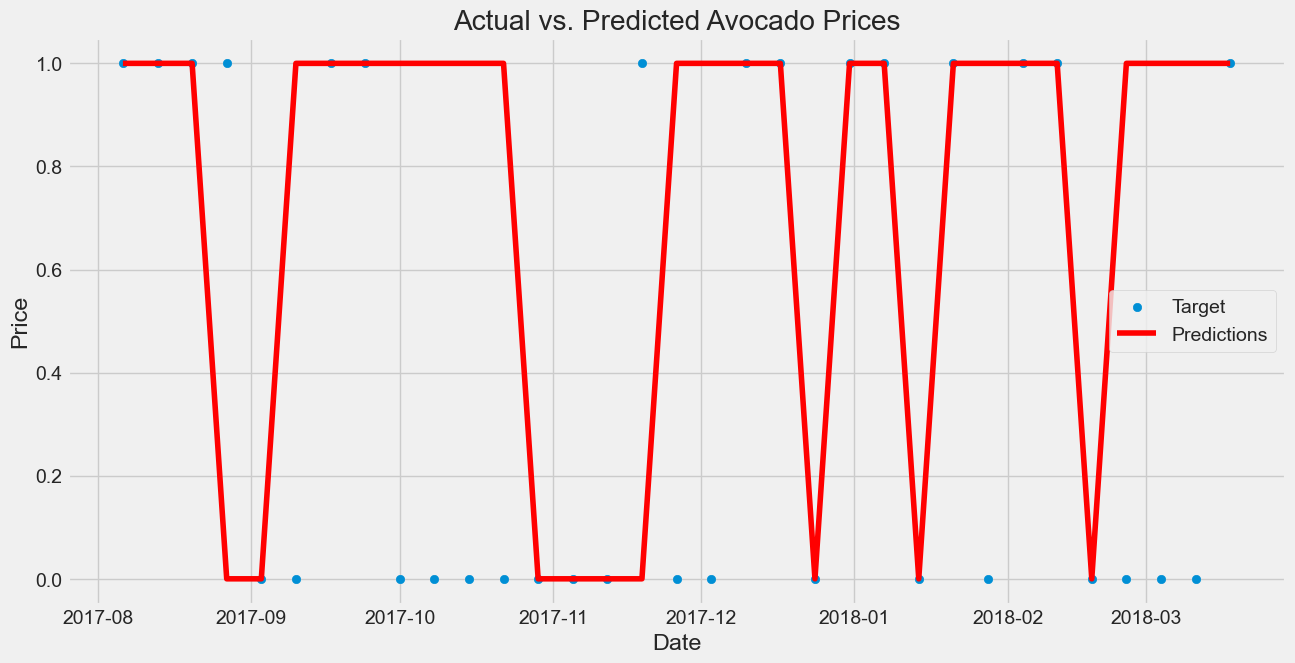

In [363]:
plt.figure(figsize=(14, 7))

# Line plot for Actual values
plt.scatter(LSTM_results.index, LSTM_results['Target'], label='Target', marker='o', linestyle='-')

# Scatter plot for Predictions
plt.plot(LSTM_results.index, LSTM_results['Predictions'], color='red', label='Predictions')

plt.title('Actual vs. Predicted Avocado Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [364]:
LSTM3_predictions_final = pd.concat([avocado["AveragePrice"], LSTM_results], axis=1).dropna()

In [365]:
# Shift the Opening Price by 1 to align the selling price with the buying day
LSTM3_predictions_final['Next_week'] = LSTM3_predictions_final['AveragePrice'].shift(-1)

# Calculate profit for days where the model predicts an increase
# Profit = Next day's opening (selling price) - Today's opening (buying price)
LSTM3_predictions_final['Profit'] = np.where(LSTM3_predictions_final['Predictions'] == 1, 
                                            LSTM3_predictions_final['Next_week']*100 - LSTM3_predictions_final['AveragePrice']*100, 
                                            0)

# Calculate total profit
LSTM3_total_profit = LSTM3_predictions_final['Profit'].sum()

LSTM3_total_profit

-1.0833333333333712

In [366]:
LSTM_features2 = avocado.copy()
columns = list(LSTM_features2.columns)
target_column = columns.pop(5)
columns.append(target_column)
LSTM_np_features2 = np.array(LSTM_features2[columns])

In [367]:
def backtestLSTM(data, model, start=100, step=5):
    """
    Backtesting function for LSTM models with NumPy array input.

    :param data: NumPy array containing the time-series data for backtesting.
    :param model: LSTM model to be used for prediction. Assumes the model has fit and predict methods.
    :param start: The amount of data to train the first model.
    :param step: The number of time steps to predict in each iteration.
    :return: A list of prediction arrays from each iteration.
    """
    all_predictions = []

    for i in range(start, data.shape[0], step):
        # Define the train and test datasets
        train = data[0:i]
        test = data[i:i+step]

        # Reshape data for LSTM input if necessary
        # LSTM expects input shape of [samples, features]
        trainX, trainY = train[:, :-1], train[:, -1]  # Assuming the last column is the target
        testX = test[:, :-1]

        # reshape input to be [samples, time steps, features] which is required for LSTM
        trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
        testX = testX.reshape((testX.shape[0],testX.shape[1], 1))
        # Fit the model
        model.fit(trainX, trainY, epochs=100)  # Specify epochs, batch_size, etc.
#An epoch is one complete pass through the entire training dataset. The right number of epochs depends on several factors, including the complexity of the model, the size and diversity of the dataset, and the computational resources available.
#The batch size is the number of training samples used to train the model in one iteration. It influences the model's convergence speed, memory usage, and potentially its ability to generalize.
        # Predicting
        predictions = model.predict(testX)
        predictions[predictions >=.6] = 1
        predictions[predictions <.6] = 0
        
        # Storing predictions
        all_predictions.append(predictions)
    
    # Concatenating all predictions
    # You may need to adjust this part based on how you want to use the predictions
    return np.concatenate(all_predictions)

In [368]:
LSTM3_predictions = backtestLSTM(LSTM_np_features2, LSTM_model3, start=100, step=5)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6923 - loss: 0.6742
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7173 - loss: 0.6421 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6598 - loss: 0.6224 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7432 - loss: 0.6140 
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7205 - loss: 0.5805 
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6758 - loss: 0.5917 
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7015 - loss: 0.5513 
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7118 - loss: 0.5532 
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7514 - loss: 0.5798 
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6847 - loss: 0.5651 
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6383 - loss: 0.6480 
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6211 - loss

In [369]:
LSTM3_predictions

array([[ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [nan]], dtype=float32)

In [370]:
LSTM3_preds_final = pd.DataFrame(LSTM3_predictions, columns=['Predictions'])
actuals3 = pd.DataFrame(y_test, columns=['Target'])
LSTM3_results = pd.concat([LSTM3_preds_final, actuals3], axis=1).dropna()
LSTM3_results.index = dates_test


In [371]:
LSTM3_results

Predictions  Target
2017-08-06          0.0     1.0
2017-08-13          0.0     1.0
2017-08-20          1.0     1.0
2017-08-27          0.0     1.0
2017-09-03          0.0     0.0
2017-09-10          1.0     0.0
2017-09-17          1.0     1.0
2017-09-24          1.0     1.0
2017-10-01          1.0     0.0
2017-10-08          1.0     0.0
2017-10-15          1.0     0.0
2017-10-22          1.0     0.0
2017-10-29          1.0     0.0
2017-11-05          1.0     0.0
2017-11-12          1.0     0.0
2017-11-19          1.0     1.0
2017-11-26          1.0     0.0
2017-12-03          1.0     0.0
2017-12-10          1.0     1.0
2017-12-17          1.0     1.0
2017-12-24          1.0     0.0
2017-12-31          1.0     1.0
2018-01-07          1.0     1.0
2018-01-14          1.0     0.0
2018-01-21          1.0     1.0
2018-01-28          1.0     0.0
2018-02-04          1.0     1.0
2018-02-11          1.0     1.0
2018-02-18          0.0     0.0
2018-02-25          0.0     0.0
2018-03-04          1.0     0.0
2018-03-11          0.0     0.0
2018-03-18          1.0     1.0
2018-03-25          1.0     0.0

In [372]:
LSTM3_results["Target"].value_counts(), LSTM3_results["Predictions"].value_counts()

(Target
 0.0    19
 1.0    15
 Name: count, dtype: int64,
 Predictions
 1.0    27
 0.0     7
 Name: count, dtype: int64)

In [373]:
precision_score(LSTM3_results["Target"], LSTM3_results["Predictions"])

0.4444444444444444

In [374]:
LSTM3_predictions_final = pd.concat([avocado["AveragePrice"], LSTM3_results], axis=1).dropna()
# Shift the Opening Price by 1 to align the selling price with the buying day
LSTM3_predictions_final['Next_week'] = LSTM3_predictions_final['AveragePrice'].shift(-1)

# Calculate profit for days where the model predicts an increase
# Profit = Next day's opening (selling price) - Today's opening (buying price)
LSTM3_predictions_final['Profit'] = np.where(LSTM3_predictions_final['Predictions'] == 1, 
                                            LSTM3_predictions_final['Next_week']*100 - LSTM3_predictions_final['AveragePrice']*100, 
                                            0)

# Calculate total profit
LSTM3_total_profit = LSTM3_predictions_final['Profit'].sum()

LSTM3_total_profit

-37.740740740740705